# Import libraries

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import requests
import os

# Data Exploration

In [252]:
df = pd.read_csv("nyse/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()
df.describe()

,open,low,high,volume,adj close
count,851264.000000,851264.000000,851264.000000,8.512640e+05,851264.000000
mean,64.993618,64.336541,65.639748,5.415113e+06,65.011913
std,75.203893,74.459518,75.906861,1.249468e+07,75.201216
min,1.660000,1.500000,1.810000,0.000000e+00,1.590000
25%,31.270000,30.940001,31.620001,1.221500e+06,31.292776
50%,48.459999,47.970001,48.959999,2.476250e+06,48.480000
75%,75.120003,74.400002,75.849998,5.222500e+06,75.139999
max,1584.439941,1549.939941,1600.930054,8.596434e+08,1578.130005


In [237]:
symbols = list(set(df.symbol))
len(symbols)
symbols[:10]

['AGN', 'EOG', 'CPB', 'EVHC', 'IDXX', 'SIG', 'JWN', 'JBHT', 'TAP', 'VRTX']

In [253]:
# import matplotlib.pyplot as plt2
open_close_corr = np.correlate(df['adj close'], df['open'])
vol_close_corr = np.correlate(df['adj close'], df['volume'])
print df.corr()

               open       low      high    volume  adj close
open       1.000000  0.999914  0.999928 -0.132526   0.999845
low        0.999914  1.000000  0.999889 -0.133087   0.999926
high       0.999928  0.999889  1.000000 -0.132168   0.999925
volume    -0.132526 -0.133087 -0.132168  1.000000  -0.132675
adj close  0.999845  0.999926  0.999925 -0.132675   1.000000


# Data Extractaction

Extract security of your choice and then normalize it using min_max_scalar , simple preprocessing applied to train the model better

In [254]:
df = df[df.symbol == 'AAPL']
df.drop(['symbol'],1,inplace=True)
df.head()
df.describe()

,open,low,high,volume,adj close
count,1762.000000,1762.000000,1762.000000,1.762000e+03,1762.000000
mean,79.427744,78.640034,80.140447,9.422578e+07,79.402683
std,28.339001,28.108525,28.561027,6.020519e+07,28.330794
min,27.481428,27.178572,28.000000,1.147590e+07,27.435715
25%,55.401787,54.672501,55.909286,4.917478e+07,55.450000
50%,78.742146,77.631428,79.344284,8.050385e+07,78.435711
75%,102.979998,102.500000,104.424997,1.210816e+08,103.092503
max,134.460007,131.399994,134.539993,4.702495e+08,133.000000


In [256]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.028123,0.030334,0.024806,0.244034,0.029718
2010-01-05,0.029686,0.031526,0.026268,0.302982,0.030219
2010-01-06,0.029392,0.028100,0.025785,0.275875,0.025604
2010-01-07,0.025880,0.025769,0.021454,0.234989,0.025076
2010-01-08,0.023943,0.025783,0.021454,0.218903,0.026971


[ 3299.30614848]
[ 137.41541209]


# Training Testing Data

Split training and testing dataset with 90/10 split

In [241]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], -1))
    x_test = np.reshape(x_test, (x_test.shape[0], -1))  

    return [x_train, y_train, x_test, y_test]

In [242]:
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

(array([ 0.02812312,  0.03033377,  0.02480624,  0.24403431,  0.02971784]), 0.030218539942430012)


# Model

Get SVR model and train on the input data, use grid search to find the perfect hyper parameters for model training and use that for training and testing going forward

In [243]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

test_model = SVR()
r2scorer = make_scorer(r2_score)
parameters = {'kernel':('rbf', 'poly'), 'C':[1, 10]}
grid = GridSearchCV(test_model, parameters, scoring=r2scorer)

In [244]:
grid.fit(X_train,y_train)
print grid.best_params_

{'kernel': 'rbf', 'C': 1}


In [245]:
model = SVR(kernel='rbf', C=1)
model.fit(X_train,y_train)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Calculate Training/Testing Score
Calculate R^2 score for training and testing datasets

In [246]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.score(X_train, y_train)
    print('Train R^2 Score: %.5f ' % (trainScore))

    testScore = model.score(X_test, y_test)
    print('Test R^2 Score: %.5f ' % (testScore))
    return trainScore, testScore


model_score(model, X_train, y_train, X_test, y_test)

Train R^2 Score: 0.98218 
Test R^2 Score: 0.94661 


(0.98217507520182534, 0.94661170931485072)

# Visualize Prediction

Denormalize test values and predicted values and plot them to measure how successful the model is in getting trained on AAPL stock

In [247]:
df = pd.read_csv("nyse/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'AAPL']
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

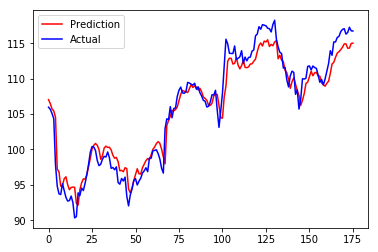

In [248]:
import matplotlib.pyplot as plt2
# print newp
plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()